<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Udesha-/EN_DE_LSTM_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB%20new%20updated(Only%20actual).csv')
df = df.rename(columns = {'Time Stamp': 'Date & Time','Actual Total WTG Output Power /kW':'Active_Power(kW)','Forecasted Power':'Forecasted_Power(kW)'}, inplace = False)
df=df[['Date & Time','Active_Power(kW)']]
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format="%m/%d/%Y %H:%M")
df.index = df['Date & Time']
df=df[['Active_Power(kW)']]
df=df[1:]
df.head()

,Active_Power(kW)
Date & Time,
2021-09-01 00:00:00,93793.5
2021-09-01 00:10:00,95265.2
2021-09-01 00:20:00,96545.6
2021-09-01 00:30:00,97879.0
2021-09-01 00:40:00,97867.2


In [ ]:
df=df.resample('1H').mean()
df.head()
validate=df.tail(1)
df=df.head(2927)

In [ ]:
df.describe()

,Active_Power(kW)
count,2927.000000
mean,41650.780617
std,36376.916742
min,0.000000
25%,10262.683333
50%,28659.500000
75%,78595.466667
max,103502.850000


In [ ]:
uni_data = df[['Active_Power(kW)']]
uni_data.head()

,Active_Power(kW)
Date & Time,
2021-09-01 00:00:00,96544.433333
2021-09-01 01:00:00,98213.050000
2021-09-01 02:00:00,98289.633333
2021-09-01 03:00:00,98307.483333
2021-09-01 04:00:00,100630.066667


In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 10
horizon = 1
TRAIN_SPLIT = 2000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.93277077]
 [0.94889223]
 [0.94963214]
 [0.9498046 ]
 [0.9722444 ]
 [0.98117797]
 [0.98169567]
 [0.88419514]
 [0.56910381]
 [0.57500285]]

 Target horizon
[[0.59087181]]


In [ ]:
BATCH_SIZE = 40
BUFFER_SIZE = 20
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
ED_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 10, 100)           40800     
                                                                 
 lstm_26 (LSTM)              (None, 10, 50)            30200     
                                                                 
 lstm_27 (LSTM)              (None, 15)                3960      
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 15)            0         
 or)                                                             
                                                                 
 lstm_28 (LSTM)              (None, 1, 100)            46400     
                                                                 
 lstm_29 (LSTM)              (None, 1, 50)             30200     
                                                      

In [ ]:
EVALUATION_INTERVAL = 50
EPOCHS = 25
history = ED_lstm_model.fit(train_univariate, epochs=25,steps_per_epoch=100,validation_data=val_univariate, validation_steps=20,verbose =1)

Epoch 1/25
100/100 [==============================] - 14s 44ms/step - loss: 0.1770 - val_loss: 0.0167
Epoch 2/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0531 - val_loss: 0.0164
Epoch 3/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0463 - val_loss: 0.0149
Epoch 4/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0371 - val_loss: 0.0129
Epoch 5/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0283 - val_loss: 0.0092
Epoch 6/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0210 - val_loss: 0.0073
Epoch 7/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0171 - val_loss: 0.0063
Epoch 8/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0138 - val_loss: 0.0081
Epoch 9/25
100/100 [==============================] - 3s 25ms/step - loss: 0.0119 - val_loss: 0.0079
Epoch 10/25
100/100 [==============================] - 3s 26ms/step - loss: 0.0106 - val_l

In [ ]:
# create model
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, TimeDistributed
enco_deco = Sequential()
# Encoder
enco_deco.add(LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True))
enco_deco.add(LSTM(units=50,return_sequences=True))
enco_deco.add(LSTM(units=15))
#feature vector
enco_deco.add(layers.RepeatVector(y_train_uni.shape[1]))
#decoder
enco_deco.add(LSTM(units=100,return_sequences=True))
enco_deco.add(LSTM(units=50,return_sequences=True))
enco_deco.add(TimeDistributed(tf.keras.layers.Dense(units=1)))

In [ ]:
enco_deco.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 10, 100)           40800     
                                                                 
 lstm_31 (LSTM)              (None, 10, 50)            30200     
                                                                 
 lstm_32 (LSTM)              (None, 15)                3960      
                                                                 
 repeat_vector_6 (RepeatVect  (None, 1, 15)            0         
 or)                                                             
                                                                 
 lstm_33 (LSTM)              (None, 1, 100)            46400     
                                                                 
 lstm_34 (LSTM)              (None, 1, 50)             30200     
                                                      

In [ ]:
uni = df['Active_Power(kW)']
validatehori = uni.tail(10)

In [ ]:
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

In [ ]:
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [ ]:
val_rescaled

array([[[0.67088062],
        [0.99523601],
        [0.64684089],
        [1.        ],
        [0.71950036],
        [0.42987731],
        [0.53418865],
        [0.58312683],
        [0.29764552],
        [0.        ]]])

In [ ]:
Predicted_results = ED_lstm_model.predict(val_rescaled)

In [ ]:
Predicted_results

array([[[0.05566374]]], dtype=float32)

In [ ]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results[0])

In [ ]:
Predicted_inver_res

array([[11155.96]], dtype=float32)

In [ ]:
validate.to_numpy()

array([[17639.81666667]])

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(validate,Predicted_inver_res)}')
    print(f'MAE is : {metrics.mean_absolute_error(validate,Predicted_inver_res)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(validate,Predicted_inver_res))}')
    print(f'MAPE is : {mean_absolute_percentage_error(validate,Predicted_inver_res)}')
    print(f'R2 is : {metrics.r2_score(validate,Predicted_inver_res)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res)

Evaluation metric results:-
MSE is : 42040397.780429065
MAE is : 6483.856705729166
RMSE is : 6483.856705729166
MAPE is : 36.756939305279055
R2 is : nan



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


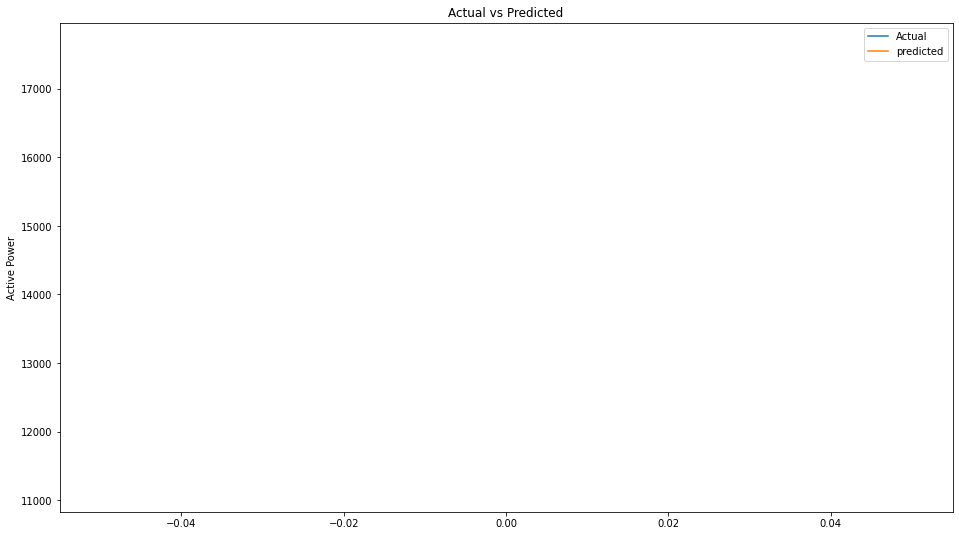

In [ ]:
plt.plot( list(validate.to_numpy()))
plt.plot( list(Predicted_inver_res))
plt.title("Actual vs Predicted")
plt.ylabel("Active Power")
plt.legend(('Actual','predicted'))
plt.rcParams["figure.figsize"] = [16,9]
plt.show()